In [3]:
# File at $MY_HOME/alt_haplotypes/src/localize/localize_unknown_decoys.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import sys

idx_to_global_region = np.load('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/idx_to_global_region.npy', allow_pickle=True).item()


N = 6895

LIKELIHOOD_FILE_DIR = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/unplaced_decoy_seqs/'
LOCALIZED_FILE_DIR = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unplaced_decoy_seqs/'

print("Loading regions....")
regions = np.loadtxt(LIKELIHOOD_FILE_DIR + 'global_regions_phasings.tsv', delimiter='\t', max_rows=100)
regions_t = regions.transpose()

Loading regions....


In [37]:
def GlobalInterval(L, std_thresh=1):
    '''
        Returns the the smallest and largest position where the likelihood is <=1 standard deivation away from the maximum likelihood.
                Parameters:
                        L (array): Array of likelihoods for each global genomic region.
                        std_thresh (float): Number of standard deviations away from the maximum likelihood to consider.

                Returns:
                        interval (tuple): The start and end idxs.
        '''    
    thresh = np.max(L) - std_thresh*np.std(L)
    if len(np.where(L>thresh)[0])==0: return (np.nan, np.nan, np.nan)
    start = np.where(L>thresh)[0][0]
    end = np.where(L>thresh)[0][-1]
    start = idx_to_global_region[start]
    end = idx_to_global_region[end]
    start_chr = int(start.split('.')[0].replace('chr', '').replace('XX', '23').replace('YY', '24'))
    end_chr = int(end.split('.')[0].replace('chr', '').replace('XX', '23').replace('YY', '24'))
    start_loci = int(start.split('.')[1])
    end_loci = int(end.split('.')[-1])
    if start_chr!=end_chr: return (np.nan, np.nan, np.nan)
    return (start_chr, start_loci, end_loci)


full_df = np.zeros((N,7)) + np.nan
nth_start = 0
n_rows=N
max_chunk=1000

for start in np.arange(nth_start,nth_start + n_rows, max_chunk):
    if start!=6000: continue
    print(start)
    print('Loading likelihoods...')
    L = np.loadtxt(LIKELIHOOD_FILE_DIR + 'likelihood_matrix_phasings_kmers.tsv' ,
                  delimiter='\t',max_rows=max_chunk, skiprows=start)
    print("Matrix multiplication...")
    
    
    kmer_counts = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/unplaced_decoy_seqs_kmer_counts.tsv',
                            header=None, index_col=0, nrows=max_chunk,skiprows=start)

    kmer_names = pd.read_table(
        '/home/groups/dpwall/briannac/alt_haplotypes/data/unplaced_decoy_seqs_kmers.txt',
    sep='\t', header=None, nrows=max_chunk, skiprows=start)
    
    L[np.isinf(L)] = L[~np.isinf(L)].min()
    likelihoods = np.matmul(L, regions_t)
    localized_regions_10 = [GlobalInterval(l,.1)  for l in likelihoods]

        
    start_idx =  start-nth_start
    kmer_chrom = [int(c.split('_')[0].replace('chr', '').replace('X', '23').replace('Y', '24').replace('Un', '-1')) for c in kmer_names[1]]

    kmer_loci = [-1 for c in kmer_names[2]]
    full_df[start_idx:(start_idx+len(L)),0] = kmer_chrom
    full_df[start_idx:(start_idx+len(L)),1] = kmer_loci

    # Some metrics about the ground truth kmers.
    full_df[start_idx:(start_idx+len(L)),2] = kmer_counts.apply(axis=1, func=lambda x: round(x[x!=0].median(), 1))
    full_df[start_idx:(start_idx+len(L)),3] = np.round((kmer_counts>0).mean(axis=1), 3)

    # Our predicted region.
    full_df[start_idx:(start_idx+len(L)),4:7] = localized_regions_10 #[np.array(l) for l in localized_regions]
    
    if len(L) < max_chunk: break

#np.savetxt(LOCALIZED_FILE_DIR + 'localized.tsv' , np.array(full_df),
#           header='\t'.join(['chrom_true', 'loci_true', 'median_of_nonzeros', 'prevalence', 'chrom_pred', 'start_pred', 'end_pred']), delimiter='\t')
    

6000
Loading likelihoods...
Matrix multiplication...


In [36]:
L[np.isinf(L)] = L[~np.isinf(L)].min()

In [28]:
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']


# Load in k-mer counts.
#family = family_info.index[IDX]
#print('family ', family)
#samples = [family_info.iloc[IDX]['mother_sample'], family_info.iloc[IDX]['father_sample']] +  family_info.iloc[IDX]['sib_samples']
bam_mappings['counter_idx'] = [i for i in range(len(bam_mappings))]
#cols_in_df = bam_mappings.loc[samples].counter_idx.values
#print(samples)

In [63]:
b = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/unplaced_decoy_seqs/global_regions_phasings.tsv', nrows=10)
b

,1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.8266,0.8267,0.8268,0.8269,0.8270,1.725,0.8271,0.8272,1.726,0.8273
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [29]:
kmer_length=100
ihart_flagstat_file = '/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv'
flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)
flagstat = flagstat.loc[set(flagstat.index).intersection(bam_mappings.index)]
sex = bam_mappings.loc[flagstat.index].sex_numeric
#bam_mappings = bam_mappings.loc[set(flagstat.index).intersection(bam_mappings.index)]
total_mapped_reads = flagstat.ProperPair*((flagstat.Total_Reads-flagstat.Supplementary-flagstat.Duplicates)/flagstat.Total_Reads)
avg_coverage = total_mapped_reads*150/(6.27e9*(sex.astype(float)==1.0) + 6.37e9*(sex.astype(float)==2.0))
avg_n_100mers = (150-kmer_length)/(150/avg_coverage)
kmer_depth_dict = {k:avg_n_100mers[k] if k in avg_n_100mers else np.mean(avg_n_100mers.values) for k in bam_mappings.index}
avg_k_depth = np.mean(list(kmer_depth_dict.values()))


In [32]:
#kmer_depth_dict

In [8]:
localized_df = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/ground_truth/localized_000.txt',
           delimiter='\t')
localized_df = localized_df[localized_df.prevalence>0]

In [15]:
could_not_localize = localized_df[np.isnan(localized_df['chrom_pred'])]
could_localize = localized_df[~np.isnan(localized_df['chrom_pred'])]

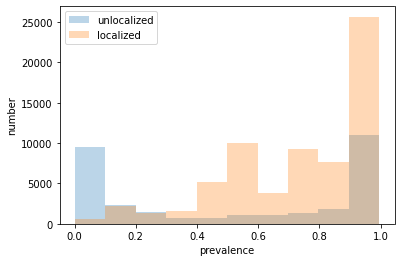

In [19]:
plt.hist(could_not_localize.prevalence, alpha=.3)
plt.hist(could_localize.prevalence, alpha=.3)
plt.legend(['unlocalized', 'localized'])
plt.xlabel('prevalence')
plt.ylabel('number')
plt.show()

In [26]:
correct = could_localize[(could_localize['# chrom_true']==could_localize['chrom_pred']) & 
              (could_localize['loci_true']<=could_localize['end_pred']) & 
              (could_localize['loci_true']>=could_localize['start_pred'])]

incorrect = could_localize[(could_localize['# chrom_true']!=could_localize['chrom_pred']) |
              (could_localize['loci_true']>could_localize['end_pred']) & 
              (could_localize['loci_true']<could_localize['start_pred'])]

In [30]:
len(correct)/(len(incorrect) + len(correct))

0.9974444692073398

(array([[0.0000e+00, 5.0000e+00, 5.5000e+01, 4.3200e+02, 1.4070e+03,
         1.0800e+02, 2.4000e+01, 3.1300e+02, 1.8000e+01, 1.9700e+02],
        [1.6500e+02, 3.0600e+02, 3.8200e+02, 4.3800e+02, 8.1700e+02,
         5.9000e+01, 1.3900e+02, 1.0990e+03, 1.5420e+03, 1.8660e+03],
        [6.5000e+01, 2.6200e+02, 4.2000e+02, 7.7000e+01, 1.3300e+02,
         3.2200e+02, 4.6600e+02, 1.2510e+03, 9.3300e+02, 9.4620e+03],
        [1.7800e+02, 5.5100e+02, 2.9300e+02, 3.6000e+02, 1.5120e+03,
         8.3620e+03, 3.4860e+03, 6.2070e+03, 1.8330e+03, 1.3653e+04],
        [1.6500e+02, 8.5100e+02, 1.0900e+02, 3.5900e+02, 9.1700e+02,
         3.1100e+02, 2.2700e+02, 2.0600e+02, 5.3100e+02, 2.8730e+03],
        [2.6600e+02, 6.7000e+01, 4.5000e+01, 4.3000e+01, 7.9000e+01,
         7.0000e+01, 4.5000e+01, 5.0000e+01, 5.8000e+01, 3.7600e+02],
        [1.1400e+02, 2.0000e+01, 1.0000e+00, 1.0000e+00, 1.1000e+01,
         1.7000e+01, 2.0000e+01, 5.0000e+00, 6.0000e+00, 3.5000e+01],
        [1.0000e+01, 3.0000

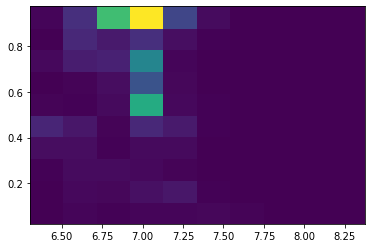

In [41]:
plt.hist2d(x=np.log10(correct.end_pred-correct.start_pred).values, y=correct.prevalence, )